In [1]:
from pyforest import *
from statsmodels.formula.api import ols
import statsmodels.api as sm
from fancyimpute import KNN
import scipy.stats as stats
import seaborn as sn
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.externals import joblib 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
from prettytable import PrettyTable


Using TensorFlow backend.
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#read data
bike_rent = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0103/day.csv")

In [3]:
#view to 5 rows 
bike_rent.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
bike_rent.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [5]:
#Change Column Names
bike_rent = bike_rent.rename(columns={'dteday':'date','yr':'year','mnth':'month','weathersit':'weather_condition','temp':'temprature','atemp':'feeling_temprature','hum':'humidity','casual':'casual_count','registered':'registered_count','cnt':'total_count'})

In [6]:
#Data Information
bike_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant               731 non-null int64
date                  731 non-null object
season                731 non-null int64
year                  731 non-null int64
month                 731 non-null int64
holiday               731 non-null int64
weekday               731 non-null int64
workingday            731 non-null int64
weather_condition     731 non-null int64
temprature            731 non-null float64
feeling_temprature    731 non-null float64
humidity              731 non-null float64
windspeed             731 non-null float64
casual_count          731 non-null int64
registered_count      731 non-null int64
total_count           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


# There is no missing data.

In [7]:
bike_rent.head()

,instant,date,season,year,month,holiday,weekday,workingday,weather_condition,temprature,feeling_temprature,humidity,windspeed,casual_count,registered_count,total_count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
plot_bike_rent = bike_rent.copy()

In [9]:
plot_bike_rent['season']=bike_rent.season.map({1:'springer', 2:'summer', 3:'fall', 4:'winter'})
plot_bike_rent['year']=bike_rent.year.map({0: '2011', 1:'2012'})
plot_bike_rent['month']=bike_rent.month.map({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'})
plot_bike_rent['holiday']=bike_rent.holiday.map({0:'No',1:'yes'})
plot_bike_rent['weekday']=bike_rent.weekday.map({0:'Sun',1:'Mon', 2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})
plot_bike_rent['workingday']=bike_rent.workingday.map({0:'Holiday/Weekend',1:'Working_day'})
plot_bike_rent['weather_condition']=bike_rent.weather_condition.map({1: 'Clear, Few clouds, Partly cloudy, Partly cloudy',
2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'})

In [10]:
temp_var = ['season','year','month','holiday','weekday','workingday','weather_condition']
for var in temp_var:
    bike_rent[var] = bike_rent[var].astype("category")

# Outliner Analysis

In this data set we will check outliner analysis for 'float64' and 'int64' data types only.

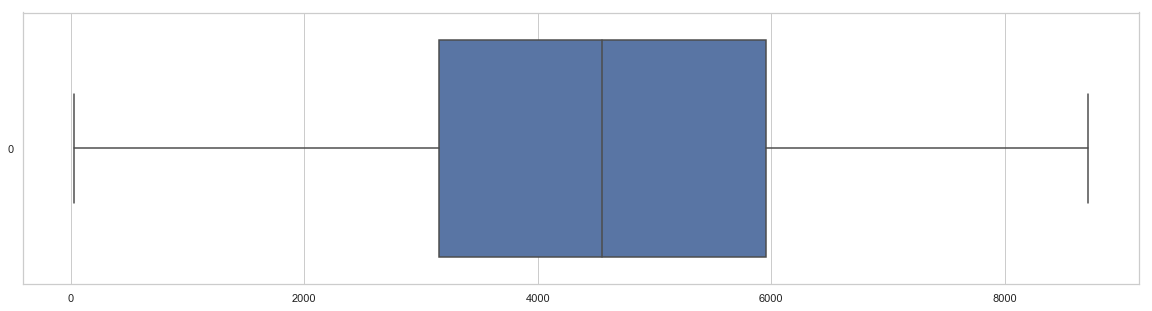

In [11]:
sns.set(style="whitegrid")
%matplotlib inline
plt.figure(figsize = (20,5))
box_plot_total = sns.boxplot(data=bike_rent['total_count'],orient='h')
box_plot_total.figure.savefig("box_plot_total.png")

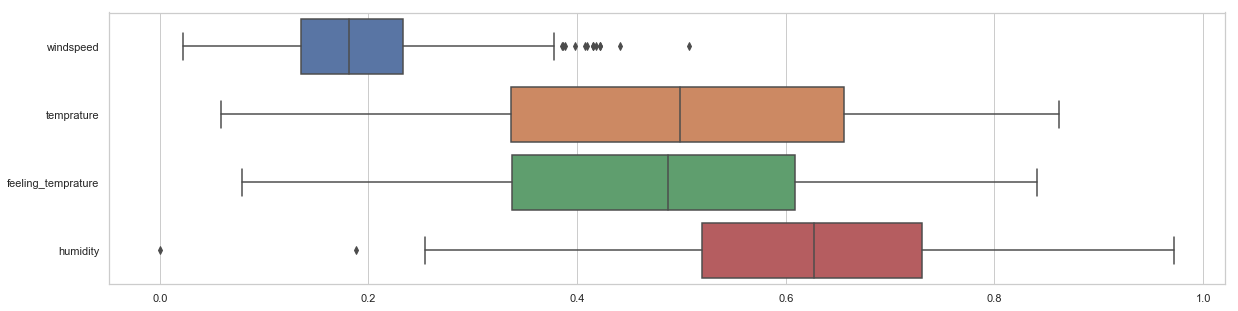

In [12]:
sns.set(style="whitegrid")
%matplotlib inline
plt.figure(figsize = (20,5))
box_plot = sns.boxplot(data=bike_rent[{'temprature','feeling_temprature','humidity','windspeed'}],orient='h')
box_plot.figure.savefig("box_plot.png")


In [13]:
#Outliner Analysis
q75, q25 = np.percentile(bike_rent['feeling_temprature'], [75 ,25])

#Calculate IQR
iqr = q75 - q25

#Calculate inner and outer fence
minimum = q25 - (iqr*1.5)
maximum = q75 + (iqr*1.5)

#Replace with NA
bike_rent.feeling_temprature[bike_rent.feeling_temprature < minimum] = np.nan
bike_rent.feeling_temprature[bike_rent.feeling_temprature > maximum] = np.nan
pd.DataFrame(bike_rent.isnull().sum())

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,0
instant,0
date,0
season,0
year,0
month,0
holiday,0
weekday,0
workingday,0
weather_condition,0
temprature,0


In [14]:
#Outliner Analysis
q75, q25 = np.percentile(bike_rent['temprature'], [75 ,25])

#Calculate IQR
iqr = q75 - q25

#Calculate inner and outer fence
minimum = q25 - (iqr*1.5)
maximum = q75 + (iqr*1.5)

#Replace with NA
bike_rent.temprature[bike_rent.temprature < minimum] = np.nan
bike_rent.temprature[bike_rent.temprature > maximum] = np.nan
pd.DataFrame(bike_rent.isnull().sum())

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,0
instant,0
date,0
season,0
year,0
month,0
holiday,0
weekday,0
workingday,0
weather_condition,0
temprature,0


In [15]:
#Outliner Analysis
q75, q25 = np.percentile(bike_rent['windspeed'], [75 ,25])

#Calculate IQR
iqr = q75 - q25

#Calculate inner and outer fence
minimum = q25 - (iqr*1.5)
maximum = q75 + (iqr*1.5)

#Replace with NA
bike_rent.windspeed[bike_rent.windspeed < minimum] = np.nan
bike_rent.windspeed[bike_rent.windspeed > maximum] = np.nan
pd.DataFrame(bike_rent.isnull().sum())

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,0
instant,0
date,0
season,0
year,0
month,0
holiday,0
weekday,0
workingday,0
weather_condition,0
temprature,0


In [16]:
#Outliner Analysis
q75, q25 = np.percentile(bike_rent['humidity'], [75 ,25])

#Calculate IQR
iqr = q75 - q25

#Calculate inner and outer fence
minimum = q25 - (iqr*1.5)
maximum = q75 + (iqr*1.5)

#Replace with NA
bike_rent.humidity[bike_rent.humidity < minimum] = np.nan
bike_rent.humidity[bike_rent.humidity > maximum] = np.nan
pd.DataFrame(bike_rent.isnull().sum())

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,0
instant,0
date,0
season,0
year,0
month,0
holiday,0
weekday,0
workingday,0
weather_condition,0
temprature,0


In [17]:
#Missing Value Analysis
missing_value = pd.DataFrame(bike_rent.isnull().sum())
missing_value = missing_value.reset_index()
missing_value = missing_value.rename(columns = {'index':'variables',0:'missing_percentage'})
missing_value['missing_percentage']=(missing_value['missing_percentage']/len(bike_rent))*100
missing_value = missing_value.sort_values('missing_percentage', ascending= False)
missing_value

,variables,missing_percentage
12,windspeed,1.778386
11,humidity,0.273598
0,instant,0.000000
1,date,0.000000
2,season,0.000000
3,year,0.000000
4,month,0.000000
5,holiday,0.000000
6,weekday,0.000000
7,workingday,0.000000


Missing values are very less in percentage so we can drop those values.

In [18]:
bike_rent = bike_rent.dropna()

# Data Visulization

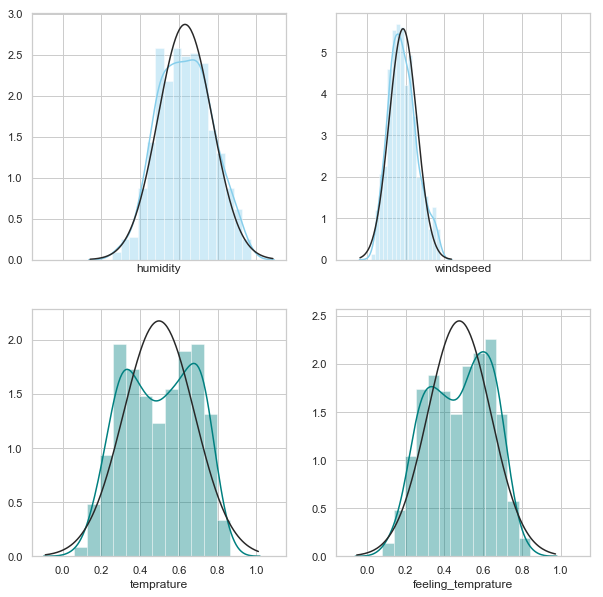

In [19]:
f, axes = plt.subplots(2,2, figsize=(10, 10), sharex=True)
sns.distplot( bike_rent["humidity"],fit=norm , color="skyblue", ax=axes[0,0])
sns.distplot( bike_rent["windspeed"],fit=norm , color="skyblue", ax=axes[0,1])
sns.distplot( bike_rent["temprature"],fit=norm , color="teal", ax=axes[1, 0])
sns.distplot( bike_rent["feeling_temprature"],fit=norm , color="teal", ax=axes[1, 1])
f.savefig("norm.png")

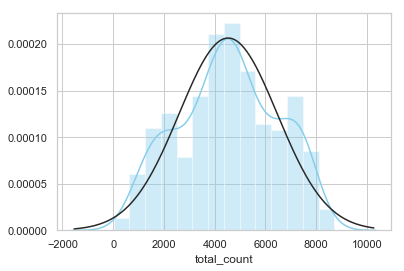

In [20]:
norm_1 = sns.distplot( bike_rent["total_count"],fit=norm , color="skyblue")
norm_1.figure.savefig("norm_1")

In [21]:
def groupandplot(data,groupby_key,value,sortorder,axes,aggregate='mean'):
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    count_data=data.groupby([groupby_key])['total_count'].count().reset_index().rename(columns={'total_count':'Num_bike_rent'})
    plot = sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data,order=sortorder,ax = axes).set_title(aggregate+'_'+value+" vs "+groupby_key)
    

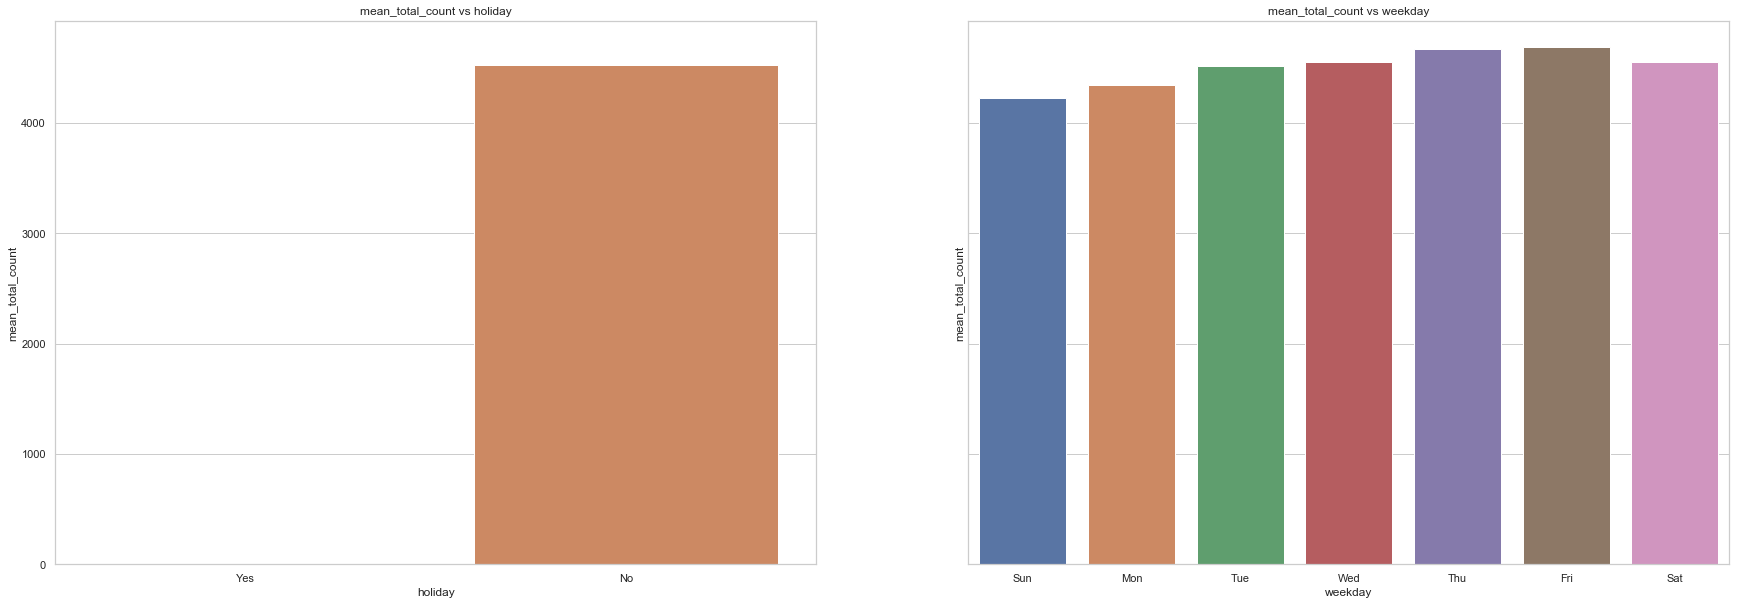

In [22]:
f, axes = plt.subplots(1,2,sharex='col', sharey='row', figsize=(30, 10))
groupandplot(plot_bike_rent,'holiday','total_count',['Yes','No'],axes[0])
groupandplot(plot_bike_rent,'weekday','total_count',['Sun','Mon', 'Tue','Wed','Thu','Fri','Sat'],axes[1])
f.savefig("b_1.png")

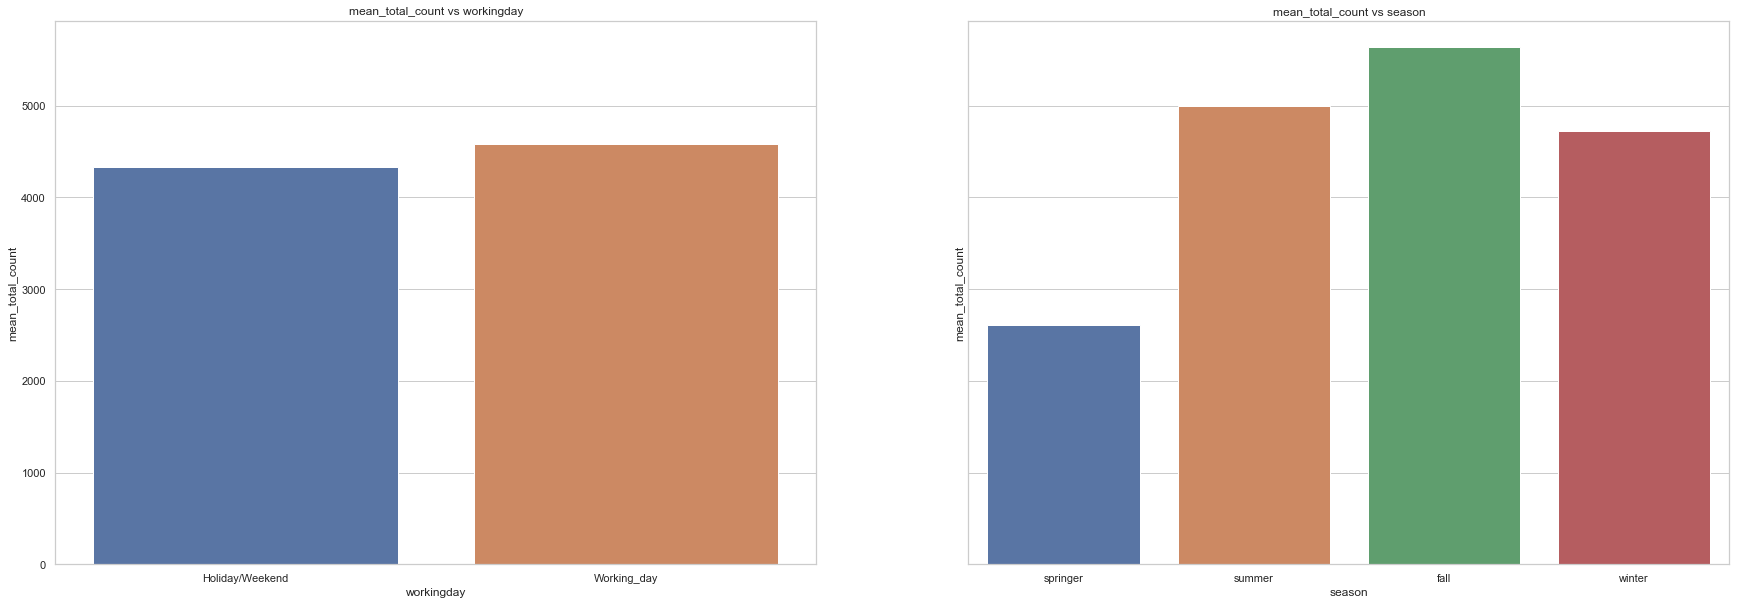

In [23]:
f, axes = plt.subplots(1,2,sharex='col', sharey='row', figsize=(30, 10))
groupandplot(plot_bike_rent,'workingday','total_count',['Holiday/Weekend','Working_day'],axes[0])
groupandplot(plot_bike_rent,'season','total_count',['springer', 'summer', 'fall', 'winter'],axes[1])
f.savefig("b_2.png")

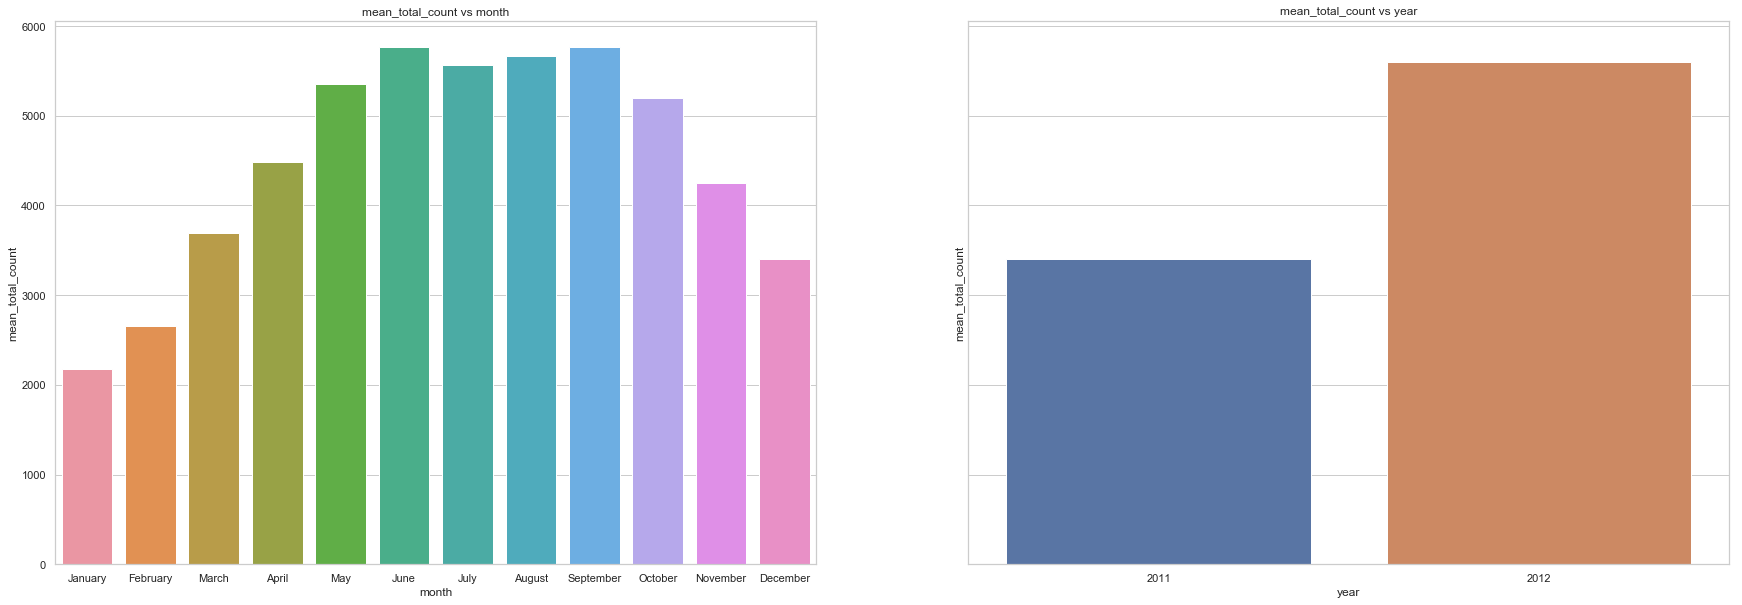

In [24]:
f, axes = plt.subplots(1,2,sharex='col', sharey='row', figsize=(30, 10))
groupandplot(plot_bike_rent,'month','total_count',["January","February","March","April","May","June","July","August","September","October","November","December"],axes[0])
groupandplot(plot_bike_rent,'year','total_count',['2011','2012'],axes[1])
f.savefig("b_3.png")

In [25]:
corr = bike_rent[['temprature','feeling_temprature','humidity','windspeed','total_count','casual_count','registered_count']].corr()
corr

,temprature,feeling_temprature,humidity,windspeed,total_count,casual_count,registered_count
temprature,1.000000,0.991738,0.114191,-0.140169,0.625892,0.539714,0.538095
feeling_temprature,0.991738,1.000000,0.126587,-0.166038,0.629204,0.540234,0.541977
humidity,0.114191,0.126587,1.000000,-0.204496,-0.136621,-0.101439,-0.124701
windspeed,-0.140169,-0.166038,-0.204496,1.000000,-0.216193,-0.146178,-0.203677
total_count,0.625892,0.629204,-0.136621,-0.216193,1.000000,0.670547,0.944581
casual_count,0.539714,0.540234,-0.101439,-0.146178,0.670547,1.000000,0.389848
registered_count,0.538095,0.541977,-0.124701,-0.203677,0.944581,0.389848,1.000000


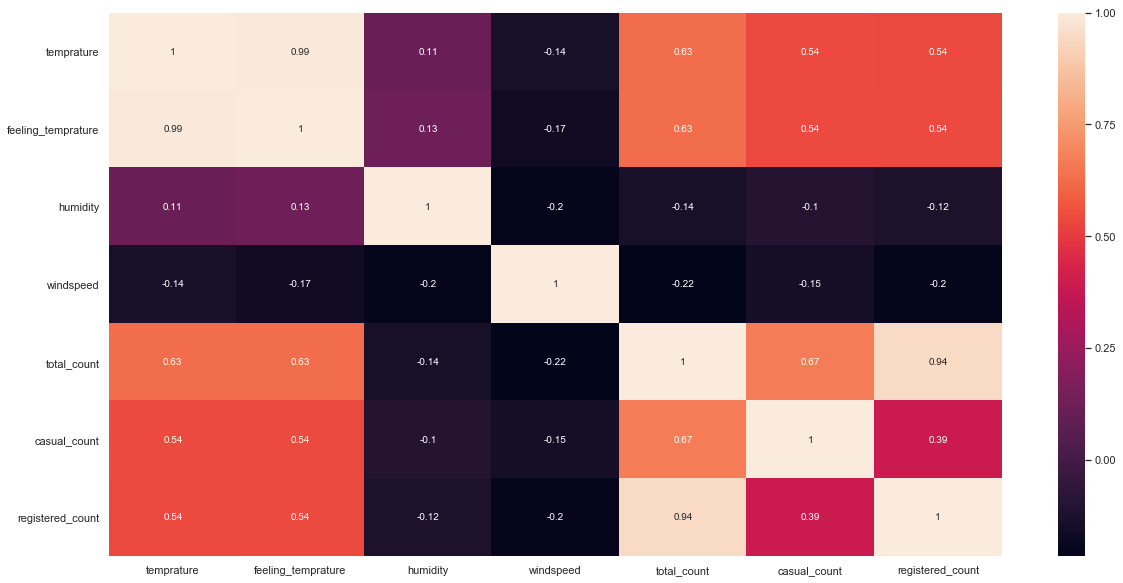

In [26]:
plt.figure(figsize=(20,10))
cor_plot = sns.heatmap(corr, annot=True)
cor_plot.figure.savefig('cor_plot.png')

Looking for continuous variables 'humidity' & 'windspeed' having very small value of coefficient of correlaiton so we will remove those variables.

In [27]:
bike_rent = bike_rent.drop(['date','instant','casual_count','registered_count'],axis=1)

In [28]:
anova = ols('total_count ~ season + year + month + holiday + weekday + workingday +weather_condition', data=bike_rent).fit()

In [29]:
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_count   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     126.5
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          2.38e-234
Time:                        21:43:55   Log-Likelihood:                -5838.8
No. Observations:                 717   AIC:                         1.173e+04
Df Residuals:                     692   BIC:                         1.184e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1117.4563    137.871      8.105      0.000     846.761    1388.152
season[T.2]              911.1484    202.128      4.508      0.000     514.291    1308.006
season[T.3]             1126.4273    235.491      4.783      0.000     664.064    1588.791
season[T.4]             1783.4306    200.305      8.904      0.000    1390.153    2176.708
year[T.1]               2145.6381     63.462     33.810      0.000    2021.036    2270.240
month[T.2]               467.3018    159.305      2.933      0.003     154.522     780.082
month[T.3]              1159.7546    172.005      6.743      0.000     822.039    1497.470
month[T.4]              1425.2243    254.978      5.590      0.000     924.601    1925.848
month[T.5]              2207.4806    253.491      8.708      0.000    1709.777    2705.184
month[T.6]              2407.7204    246.461      9.769      0.000    1923.820    2891.621
month[T.7]              2079.2882    281.037      7.399      0.000    1527.501    2631.075
month[T.8]              2211.3636    280.878      7.873      0.000    1659.888    2762.839
month[T.9]              2361.5356    257.461      9.172      0.000    1856.037    2867.034
month[T.10]             1432.5742    252.956      5.663      0.000     935.922    1929.227
month[T.11]              262.2918    253.311      1.035      0.301    -235.059     759.643
month[T.12]              206.2783    202.044      1.021      0.308    -190.415     602.971
holiday[T.1]            -147.8748    176.542     -0.838      0.403    -494.498     198.748
weekday[T.1]            -134.1732     79.694     -1.684      0.093    -290.645      22.298
weekday[T.2]              20.6581     85.494      0.242      0.809    -147.200     188.516
weekday[T.3]              91.6804     85.822      1.068      0.286     -76.822     260.183
weekday[T.4]             114.4572     85.409      1.340      0.181     -53.236     282.150
weekday[T.5]             119.2324     85.018      1.402      0.161     -47.692     286.157
weekday[T.6]             462.2570    118.649      3.896      0.000     229.301     695.213
workingday[T.1]          359.7298     74.099      4.855      0.000     214.244     505.215
weather_condition[T.2]  -725.7950     68.834    -10.544      0.000    -860.944    -590.646
weather_condition[T.3] -2659.5167    198.905    -13.371      0.000   -3050.046   -2268.988
==============================================================================
Omnibus:                      127.816   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              549.928
Skew:                          -0.750   Prob(JB):                    3.84e-120
Kurtosis:                       7.019   Cond. No.                     2.25e+15
=================================================

In [30]:
aov_table = sm.stats.anova_lm(anova,type = 1)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
season,3.0,9.218466e+08,3.072822e+08,427.956121,3.746448e-157
year,1.0,8.717574e+08,8.717574e+08,1214.108425,2.113285e-154
month,11.0,1.840912e+08,1.673556e+07,23.307849,6.624959e-41
holiday,1.0,3.612964e+06,3.612964e+06,5.031825,2.520131e-02
weekday,6.0,1.457678e+07,2.429463e+06,3.383547,2.694554e-03
workingday,1.0,5.554650e+04,5.554650e+04,0.077360,7.809900e-01
weather_condition,2.0,1.840186e+08,9.200928e+07,128.142583,4.527198e-48
Residual,692.0,4.968717e+08,7.180227e+05,NaN,NaN


By anova test 'PR(>F)'>0.05 for variable 'workingday' so we will remove that variable

In [31]:
bike_rent = bike_rent.drop(['workingday'],axis=1)

In [32]:
X = bike_rent.drop('total_count',axis=1).values
y = bike_rent['total_count'].values
X_train_bike, X_test_bike, y_train_bike, y_test_bike = train_test_split(X, y, test_size = 0.20, random_state=42)
print(X_train_bike.shape, X_test_bike.shape, y_train_bike.shape, y_test_bike.shape)

(573, 10) (144, 10) (573,) (144,)


## Model Selection

In [33]:
table = PrettyTable()
table.field_names = ["Model", "RMSE_Test","RMSE_Train","RMSLE_Test","RMSLE_Train","R² score"]

models = [
    LinearRegression(),
    DecisionTreeRegressor(),Ridge(),Lasso(),
    RandomForestRegressor( random_state=0, n_estimators=300),
    XGBRegressor(n_estimators=100)
]
for model in models:
    model.fit(X_train_bike, y_train_bike) 
    y_pred = model.predict(X_test_bike)
    y_pred_train = model.predict(X_train_bike)
    RMSE_test = np.sqrt(mean_squared_error(y_test_bike, y_pred))
    RMSLE_test = np.sqrt(mean_squared_log_error(y_test_bike, y_pred))
    RMSE_train = np.sqrt(mean_squared_error(y_train_bike, y_pred_train))
    RMSLE_train = np.sqrt(mean_squared_log_error(y_train_bike, y_pred_train))
    
    mse = mean_squared_error(y_pred, y_test_bike)
    msle = mean_squared_log_error(y_test_bike, y_pred)
    score = model.score(X_test_bike, y_test_bike)    

    table.add_row([type(model).__name__, format(RMSE_test, '.5f'),format(RMSLE_test,'.5f'),format(RMSE_train,'.5f'),format(RMSLE_train,'.5f') ,format(score, '.5f')])

print(table)

[21:43:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
+-----------------------+-----------+------------+------------+-------------+----------+
|         Model         | RMSE_Test | RMSE_Train | RMSLE_Test | RMSLE_Train | R² score |
+-----------------------+-----------+------------+------------+-------------+----------+
|    LinearRegression   | 833.41690 |  0.49307   | 877.39306  |   0.29205   | 0.81558  |
| DecisionTreeRegressor | 923.33439 |  0.51769   |  0.00000   |   0.00000   | 0.77364  |
|         Ridge         | 836.69768 |  0.49334   | 879.35492  |   0.26856   | 0.81413  |
|         Lasso         | 834.53671 |  0.49312   | 877.63980  |   0.27606   | 0.81509  |
| RandomForestRegressor | 699.26006 |  0.47783   | 247.17488  |   0.10899   | 0.87018  |
|      XGBRegressor     | 625.86782 |  0.44641   | 432.96809  |   0.13594   | 0.89600  |
+-----------------------+-----------+------------+------------+-------------+------

In [34]:
X_train_bike_df = pd.DataFrame.from_records(X_train_bike)
columns = bike_rent.columns
columns = columns.delete(10)
X_train_bike_df.columns = columns

In [35]:
def plot_regression(model,X_train, y_train):
    reg_coef_m = model.fit(X_train,y_train).coef_
    print(reg_coef_m)
    # Plot the coefficients
    plt.figure(figsize=(15,5))
    plt.plot(range(len(X_train_bike_df.columns)), reg_coef_m)
    plt.xticks(range(len(X_train_bike_df.columns)), X_train_bike_df.columns.values, rotation=60)
    plt.margins(0.02)   
    plt.show()

[  530.04336032  2059.97010786   -44.3727868   -555.48373759
    60.64546803  -545.29752752  2223.58743284  3346.57580094
 -1134.69955114 -2348.26555495]


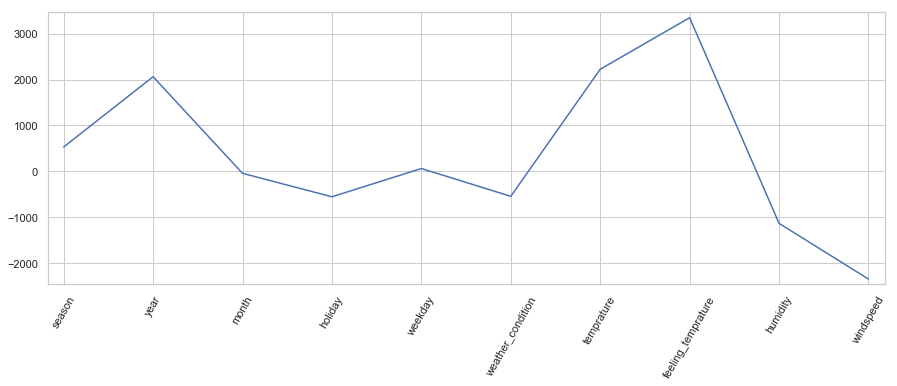

In [36]:
plot_lr = plot_regression(LinearRegression(),X_train_bike,y_train_bike)

[  531.48621761  2060.49766782   -44.08714524  -526.74349773
    60.79339808  -567.23592406  2351.62657408  3156.81593383
 -1001.99613756 -2115.81596532]


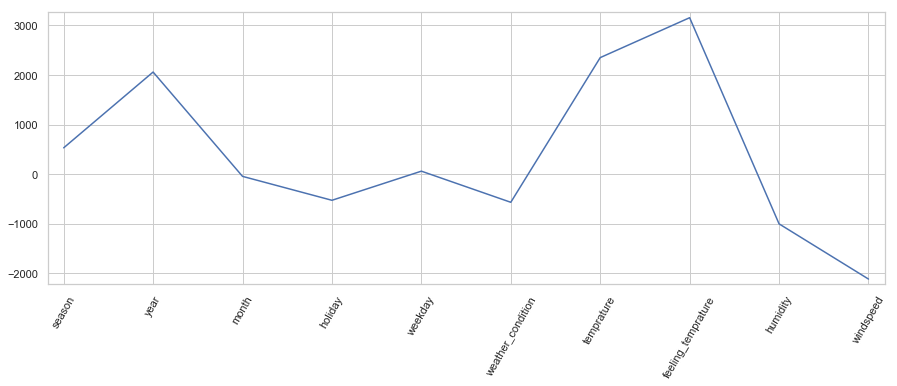

In [37]:
plot_regression(Lasso(),X_train_bike,y_train_bike)

[  545.56622755  2057.528253     -45.37369828  -533.85559998
    60.8754719   -604.57490501  2685.40543149  2623.18219349
  -835.80689689 -1706.28725435]


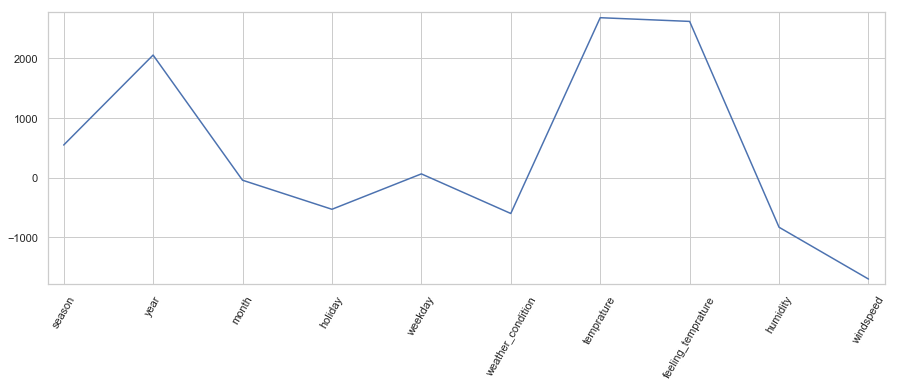

In [38]:
plot_regression(Ridge(),X_train_bike,y_train_bike)

In [39]:
def plot_importance(model, X_train_bike, y_train_bike):
    # Creating plot
    fig = plt.figure(figsize=(20,10))
    plt.title(model)
    tree_features = model.fit(X_train_bike,y_train_bike).feature_importances_
    print(tree_features)
    indices = np.argsort(tree_features)[::1]
    names = [X_train_bike_df.columns[i] for i in indices]
    # Add horizontal bars
    plt.barh(range(pd.DataFrame(X_train_bike).shape[1]),tree_features[indices],align = 'center')
    plt.yticks(range(pd.DataFrame(X_train_bike).shape[1]), names)
    plt.show()

[0.07384051 0.29715768 0.02581183 0.00181199 0.01673451 0.00426195
 0.42717015 0.04487751 0.07856211 0.02977176]


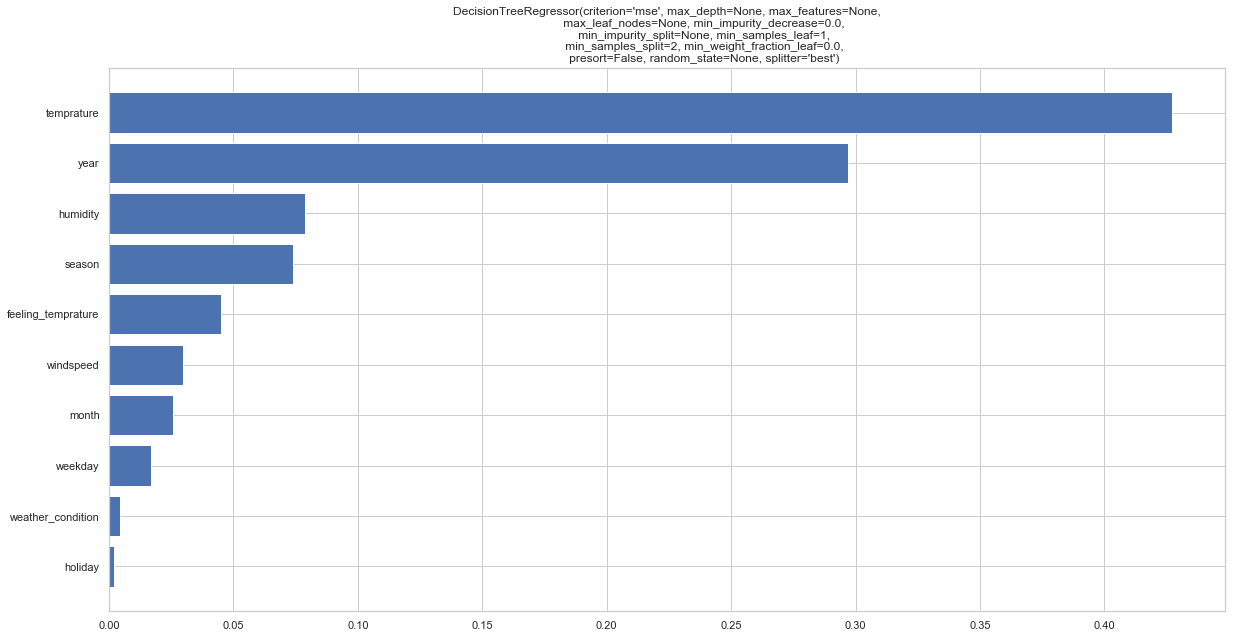

DecisionTreeRegressor None


In [40]:
print('DecisionTreeRegressor',plot_importance(DecisionTreeRegressor(),X_train_bike,y_train_bike))

[0.06429511 0.28968424 0.02827882 0.00422449 0.01334353 0.00964519
 0.31814405 0.16722259 0.07621522 0.02894676]


/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


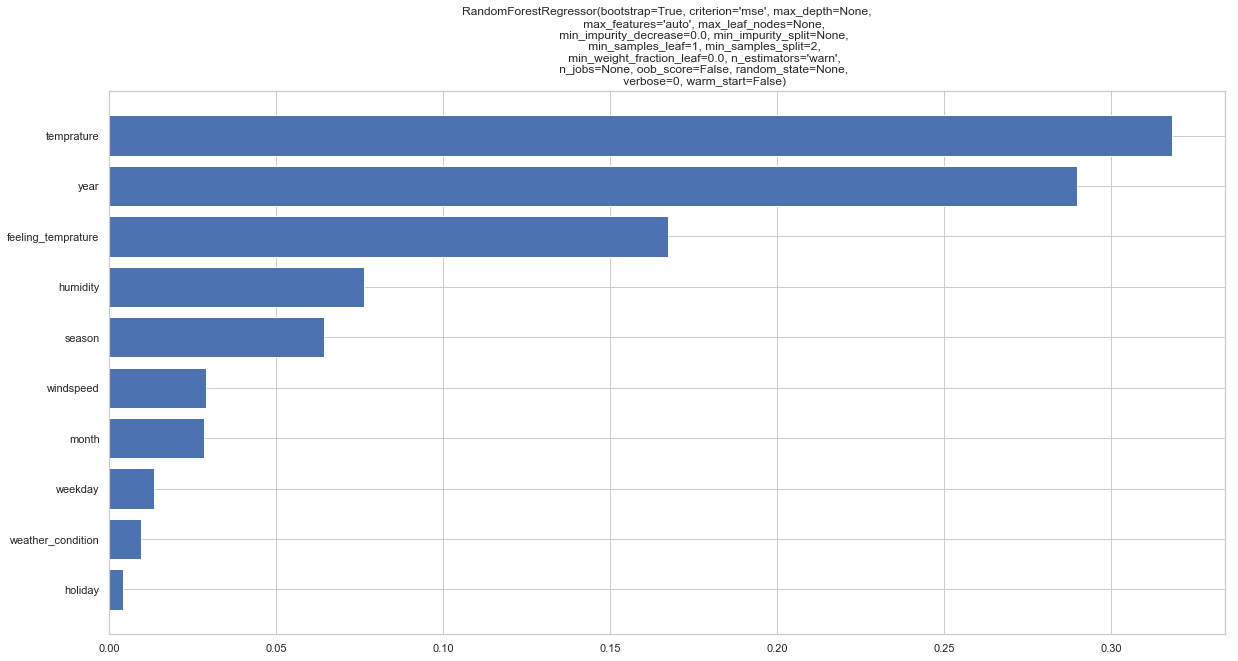

RandomForestRegressor None


In [41]:
print('RandomForestRegressor',plot_importance(RandomForestRegressor(),X_train_bike,y_train_bike))

[21:43:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.17181417 0.4615058  0.01699146 0.01979753 0.00865801 0.04914481
 0.19019859 0.0485683  0.01941875 0.01390261]


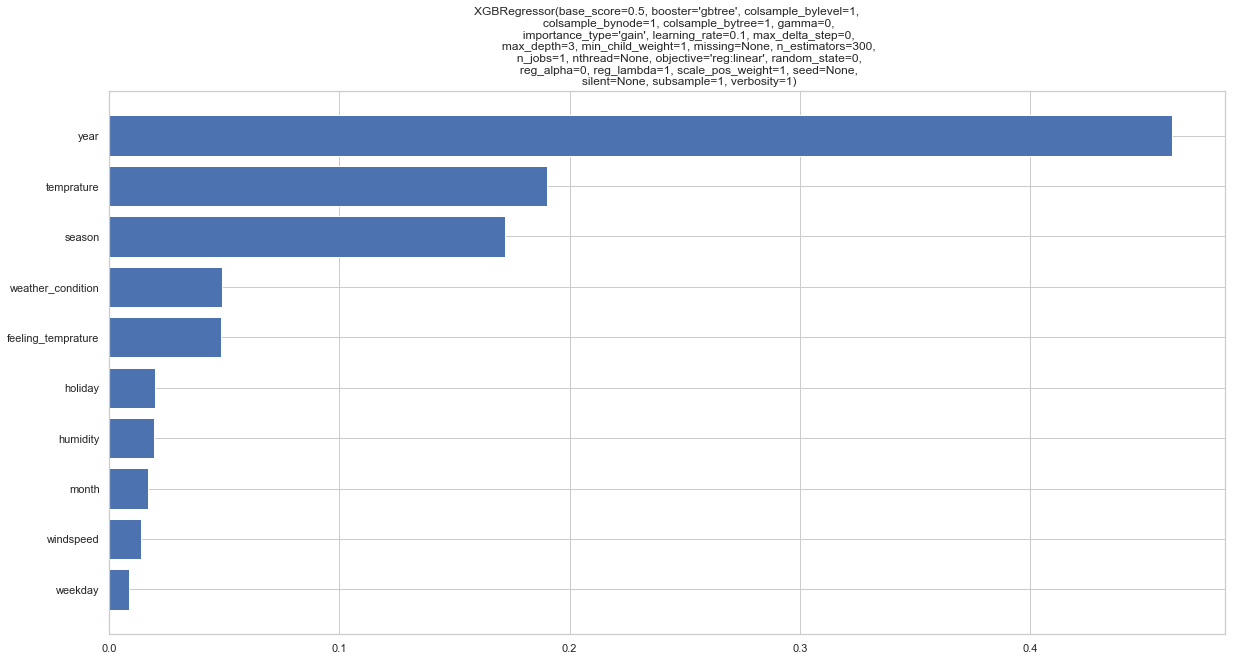

XGBRegressor None


In [42]:
print('XGBRegressor',plot_importance(XGBRegressor( random_state=0, n_estimators=300),X_train_bike,y_train_bike))

In [43]:
XGBRegressor( random_state=0, n_estimators=300).fit(X_train_bike, y_train_bike) 
y_pred = model.predict(X_test_bike)

[21:43:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [44]:
y_pred

array([4248.094  , 3296.7976 , 1410.8702 , 7176.048  , 6958.3223 ,
       6977.85   , 1404.0486 , 6587.996  , 1784.6526 , 3171.3203 ,
       5657.662  , 2046.2527 , 4631.69   , 2575.8713 , 4502.7627 ,
       4259.705  , 4566.099  , 4244.47   , 2552.6697 , 6490.8105 ,
       1920.5403 , 4531.2285 , 3892.5786 , 7383.8022 , 4540.75   ,
       3568.1277 , 4027.5376 , 2494.7432 ,  914.70514, 2984.2283 ,
       1781.3733 , 2507.1846 , 3928.576  , 5725.326  , 2397.875  ,
       2237.4111 , 3701.4094 , 7263.1895 , 4568.774  , 6700.198  ,
       4272.1733 , 6830.1035 , 7742.3257 , 4117.9023 , 5012.8174 ,
       1004.56464, 3245.9207 , 7126.9033 , 4075.3318 , 5050.302  ,
       4178.8115 , 4804.7397 , 7133.397  , 2035.8655 , 4429.6216 ,
       7381.745  , 1412.4048 , 4037.183  , 6463.4443 , 6434.7026 ,
        939.834  , 2570.37   , 2121.776  , 4805.8125 , 4668.6455 ,
       6470.6855 , 4375.8613 , 2965.8577 , 7344.9136 , 5528.701  ,
       6446.9624 , 4576.2007 , 7093.3135 , 4098.6157 , 3627.00